# Train Noisy Circle Detector
(This notebook is a good example of a standalone notebook that was run on GPU cloud instance for fast training.
The cells record the cloud output. The finished notebook and best epoch files were then downloaded locally. 
Explanations were then added to the markdown cells for clarification.)

## In this notebook:
* You'll create data from scratch
* Define a medium sized 2 dimensional convnet
* Train the model to:
    * detect a class of shape, randomly located in an image
    * detect the image regardless of noisy and incomplete data
    * perform a regression to three values:
        * the pixel row where the shape starts
        * the pixel column where the shape starts
        * the value of the radius of the circle shape
        
### Why?
Most computer vision examples and practical implementations leverage transfer learning and use a baseline image detection model and then just train off of that. While this is helpful and generally recommended, it does present challenges, pretrained image models are often:
    * large
    * complex
    * difficult to tune
    * may unnecessary features 
        * e.g. many bounding boxes, many shapes
    
Using a smaller, custom made model should be easier:
* to explore and visualize activations
* adjust and tunemodel parameters
* vet improvements to model design that may be applicable to larger models

### Baseline library installations for this notebook

In [1]:
! pip install keras matplotlib scikit-image numpy Shapely==1.6.4.post2 Pillow opencv-python tqdm

    100% |████████████████████████████████| 317kB 3.7MB/s eta 0:00:01
    100% |████████████████████████████████| 12.8MB 98kB/s  eta 0:00:01
    100% |████████████████████████████████| 25.5MB 48kB/s  eta 0:00:01
    100% |████████████████████████████████| 17.0MB 74kB/s  eta 0:00:01
    100% |████████████████████████████████| 1.4MB 978kB/s eta 0:00:01
    100% |████████████████████████████████| 2.1MB 633kB/s eta 0:00:01
    100% |████████████████████████████████| 26.6MB 48kB/s  eta 0:00:01
    100% |████████████████████████████████| 51kB 9.6MB/s eta 0:00:01
    100% |████████████████████████████████| 296kB 4.3MB/s eta 0:00:01
    100% |████████████████████████████████| 2.8MB 476kB/s eta 0:00:01
    100% |████████████████████████████████| 266kB 5.2MB/s eta 0:00:01
    100% |████████████████████████████████| 24.8MB 52kB/s  eta 0:00:01
    100% |████████████████████████████████| 51kB 11.1MB/s ta 0:00:01
    100% |████████████████████████████████| 102kB 9.7MB/s ta 0:00:01
    100% |████████

In [2]:
%matplotlib inline
from matplotlib.pyplot import imshow
import warnings
warnings.filterwarnings('ignore')
import numpy as np
# For some reason, this import works locally but complains in GCP,
# from shapely.geometry.point import Point
from skimage.draw import circle_perimeter_aa
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

import os
import sys
import random
import math
import re
import time
import cv2
import matplotlib
# Root directory of the project
ROOT_DIR = os.path.abspath(".") 
sys.path.append(ROOT_DIR)  # To find local version of the library
from PIL import Image

from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPooling2D, Flatten, Conv2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

Using TensorFlow backend.


## Some utility functions for creating and randomizing our data

In [3]:
def draw_circle(img, row, col, rad):
    """Draw a circle into a matrix."""
    rr, cc, val = circle_perimeter_aa(row, col, rad)
    valid = (
        (rr >= 0) &
        (rr < img.shape[0]) &
        (cc >= 0) &
        (cc < img.shape[1])
    )
    img[rr[valid], cc[valid]] = val[valid]

def noisy_circle(size, radius, noise):
    """Generate a random circle for an image, and add noise."""
    img = np.zeros((size, size), dtype=np.float)
    # Circle
    row = np.random.randint(size)
    col = np.random.randint(size)
    rad = np.random.randint(10, max(10, radius))
    draw_circle(img, row, col, rad)
    # Add noise
    img += noise * np.random.rand(*img.shape)
    return (row, col, rad), img

def find_circle(img):
    """
    Find the circle in the noisy image.
    param: img: a 200x200 pixel image
    returns: tuple of row, col, radius.
    """
    try:
        global the_model
        if not the_model:
            the_model = get_model()
        # normalize the data for the model
        image = (img - np.mean(img)) / np.std(img)
        results = the_model.predict(image.reshape(1, 200, 200, 1))
        row, col, rad = results[0]
        return (round(row), round(col), round(rad))
    except Exception as ex:
        print(ex) # log failure here
        print("fail!")
        return 100, 100, 30

def iou(ytrue, ypred):
    """
    Determine intersection over union percentage. 
    Area of intersection divided by area of union
    https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    """
    row0, col0, rad0 = ytrue 
    row1, col1, rad1 = ypred 
    shape0 = Point(row0, col0).buffer(rad0)
    shape1 = Point(row1, col1).buffer(rad1)
    return (shape0.intersection(shape1).area /
        shape0.union(shape1).area)

## Let's view an example of what we're searching for and the surrounding data

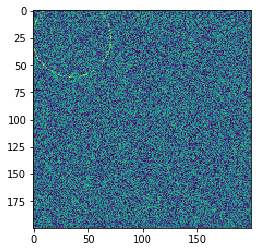

In [4]:
def show_image(an_image):
    # convert values to 0 - 255 int8 format
    formatted = (an_image * 255 / np.max(an_image)).astype('uint8')
    img = Image.fromarray(formatted)
    imshow(np.asarray(img))

params, an_image = noisy_circle(200, 50, 2)    
show_image(an_image)

# Generate random training data

In [28]:
num_imgs = 20000
img_size = 200

# set with zeros, but don't worry as they will be overwritten with noise
y = np.zeros((num_imgs, 3), dtype=np.float32)  
imgs = np.zeros((num_imgs, img_size, img_size), dtype=np.float32)  

for i_img in  range(num_imgs):
    params, img = noisy_circle(200, 50, 2)
    row, col, rad = params
    imgs[i_img] = img  
    y[i_img] = [row, col, rad ]        
imgs.shape, y.shape

((20000, 200, 200), (20000, 3))

# Reshape and normalize the image data to mean 0 and std 1.

In [29]:
img_data = (imgs  - np.mean(imgs)) / np.std(imgs)
X = img_data.reshape(img_data.shape[0], 200, 200 , 1)
X.shape, np.mean(X), np.std(X)

((20000, 200, 200, 1), 4.1315557e-06, 0.99999523)

## Delete unused data/helper objects so the training system isn't uncessarily burdened

In [30]:
del img_data 
del imgs
import gc
gc.collect()

5110

## Print the matrix shapes we'll be feeding to the model

In [31]:
print(y.shape[-1])
the_input_shape = X.shape[1:]
print(the_input_shape) 

3
(200, 200, 1)


# Split training and test

In [32]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((16000, 200, 200, 1), (16000, 3), (4000, 200, 200, 1), (4000, 3))

## Define checkpoints for early stopping and reducing the learning rate on plateau

In [37]:
filepath="noisy.circle.detector.best.epoch{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_mean_squared_error',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto')

reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_mean_squared_error', # val_loss
                                        factor=0.1, patience=10,
                                        verbose=1, mode='auto',
                                        min_delta=0.0001, cooldown=0, min_lr=0)

def step_decay(epoch):
    """learning rate schedule"""
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

# learning schedule callback
lrate = LearningRateScheduler(step_decay)

callbacks_list = [checkpoint,   reduce_lr_on_plateau] # , lrate]

# Define and build the model
## Note 
* We don't use stride, since that may lose some object edge information which is useful for detecting the boundaries

In [38]:
pool_size = 2
chanDim = -1

model = Sequential()
model.add(Conv2D(128, (9, 9),
                input_shape=the_input_shape,
                activation="relu",
                padding="same",
                name="conv2dLayer0"))
model.add(BatchNormalization(axis=chanDim, name="BatchNormalization0"))      
model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPoolingLayer1'))  
model.add(Conv2D(128, (7, 7),
                activation="relu",
                padding="same",
                name="conv2dLayer1"))
model.add(BatchNormalization(axis=chanDim, name="BatchNormalization1"))                
model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPoolingLayer2'))  
model.add(Conv2D(128, (5, 5), 
                activation="relu",
                padding="same", 
                name="conv2dLayer2"))
model.add(BatchNormalization(axis=chanDim, name="BatchNormalization2"))                
model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPoolingLayer3'))  
model.add(Conv2D(64, (3, 3),
                activation="relu",
                padding="same", 
                name="conv2dLayer3"))
model.add(BatchNormalization(axis=chanDim, name="BatchNormalization3"))     
model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPoolingLayer4'))  
model.add(Flatten(name='FlattenLayer1'))
model.add(Dropout(0.3, name='DropoutLayer1'))
model.add(Dense(64, activation='relu', name='DenseLayer1'))
model.add(Dropout(0.3, name='DropoutLayer2'))
model.add(Dense(3, activation='linear', name='DenseLayer2'))
model.compile(loss='mse',
              optimizer=RMSprop(lr=1e-2),
              metrics=['mae', 'mse'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2dLayer0 (Conv2D)        (None, 200, 200, 128)     10496     
_________________________________________________________________
BatchNormalization0 (BatchNo (None, 200, 200, 128)     512       
_________________________________________________________________
MaxPoolingLayer1 (MaxPooling (None, 100, 100, 128)     0         
_________________________________________________________________
conv2dLayer1 (Conv2D)        (None, 100, 100, 128)     802944    
_________________________________________________________________
BatchNormalization1 (BatchNo (None, 100, 100, 128)     512       
_________________________________________________________________
MaxPoolingLayer2 (MaxPooling (None, 50, 50, 128)       0         
_________________________________________________________________
conv2dLayer2 (Conv2D)        (None, 50, 50, 128)       409728    
__________

## Train the model, record callback history

In [39]:
history = model.fit(train_X, train_y,
                    epochs=100, 
                    validation_data=(test_X, test_y),
                    batch_size=32,
                    verbose=1,
                    callbacks=callbacks_list)

Train on 16000 samples, validate on 4000 samples
Epoch 1/100
16000/16000 [==============================] - 66s 4ms/step - loss: 1361.9908 - mean_absolute_error: 24.3740 - mean_squared_error: 1361.9908 - val_loss: 560.5890 - val_mean_absolute_error: 19.1637 - val_mean_squared_error: 560.5890

Epoch 00001: val_mean_squared_error improved from inf to 560.58904, saving model to noisy.circle.detector.best.epoch01.hdf5
Epoch 2/100
16000/16000 [==============================] - 64s 4ms/step - loss: 484.7816 - mean_absolute_error: 15.9182 - mean_squared_error: 484.7816 - val_loss: 550.5423 - val_mean_absolute_error: 19.6871 - val_mean_squared_error: 550.5423

Epoch 00002: val_mean_squared_error improved from 560.58904 to 550.54227, saving model to noisy.circle.detector.best.epoch02.hdf5
Epoch 3/100
16000/16000 [==============================] - 64s 4ms/step - loss: 397.8436 - mean_absolute_error: 14.3421 - mean_squared_error: 397.8436 - val_loss: 280.0837 - val_mean_absolute_error: 13.5241 - 

## Print the test results, of the final model, not necessarily the best one though

In [40]:
score = model.evaluate(test_X, test_y, verbose=0)
print('Test mean_squared_error:', score[0])
print('Test mean_absolute_error:', score[1])

Test mean_squared_error: 12.953564407348633
Test mean_absolute_error: 2.5044815216064453


In [29]:
# Often at the end of training we save the final model, but the last checkpoint provides our best model yet
# model.save('noisy.circle.detector.last.hdf5')

## Plot validation accuracy and loss

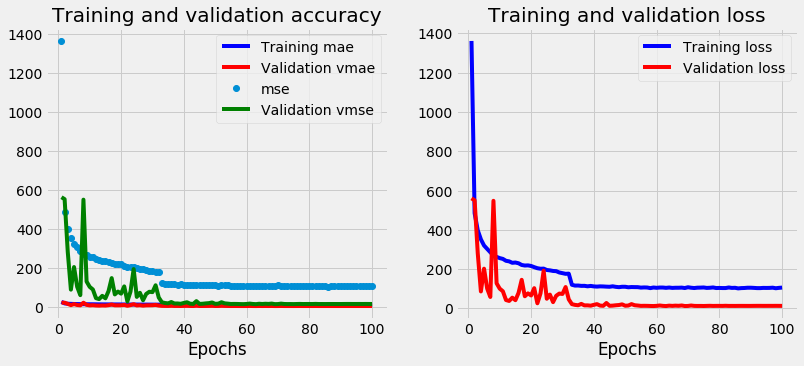

In [41]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

def plot_history(history):
    mae = history.history['mean_absolute_error']
    mse = history.history['mean_squared_error']
    vmae = history.history['val_mean_absolute_error']
    vmse = history.history['val_mean_squared_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(mae) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, mae, 'b', label='Training mae')
    plt.plot(x, vmae, 'r', label='Validation vmae')
    plt.plot(x, mse, 'o', label='mse')
    plt.plot(x, vmse, 'g', label='Validation vmse')    
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.legend()
    
plot_history(history)